# Botón Para Esconder Código

In [3]:
#Sacado de https://mljar.com/blog/jupyter-notebook-hide-code/
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Aprete aqui para visualizar/esconder bloques de codigo."></form>''')

## Libraries y Display

In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
import statistics

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Parte I: Análisis de la base de hogares y cálculo de pobreza

1) Consideramos que hay varias variables que podrían resultar importantes a la hora de mejorar el ejercicio del TP2. A continuación, divididas por sección:

Identificación:
- REGION: La pobreza no es homogenea por regiones, asumimos que según sea la región de la vivienda, la probabilidad de ser pobre varía. 

Características de la Vivienda:
- IV5/IV6/IV7/IV12_3: Ciertas caracteristicas de la vivienda que pueden demarcar pobreza. Relacionadas con necesidades básicas. Ejemplo agua o tipo de techo. IV12_3 si es o no villa de emergencia.

Características Habitacionales del Hogar:
- II7:Régimen de tenencia, según cual sea, relacionado con si es pobre o no. Ejemplo, si es ocupante de hecho, asumo que es más probable que sea pobre.
- II8: Combustible, relacionado con necesidades básicas. 

Estrategias del Hogar:
- V5: Subsidios y ayuda social por lo general va destinado a gente que lo necesita, entre las que se encuentran personas de bajos recursos/pobres.
- V17/V19_A/V12/V4: Son variables relacionadas a la necesidad de conseguir un ingreso extra. Ejemplo, menores de edad trabajando o vender pertenencias.  Comunican necesidad, relacionadas con pobreza.

Resumen del Hogar: 
- IX_MEN10: Mayor cantidad de hijos en hogares de menos recursos. 

Recordamos que esto es adicional a lo presentado en el punto 6 de la parte 2 del TP2, en el cual seleccionamos las siguientes variables de la base individual: CH04, CH06, CH08, CH09, CH10, CH11, CH12, CH13, NIVEL_ED, ESTADO, PP02E, PP02H, PP02I.

2)  Abrimos la base de datos de la EPH y nos quedamos con los observaciones de GBA.

In [5]:
#Abrimos la base
hogar = pd.read_excel('./EPH_usu_1er_Trim_2022_xlsx/usu_hogar_T122.xlsx')

#Eliminamos todos los aglomerados que no correspondan a CABA (cód 32) o GBA (cód 33)
hogar_cortado = hogar.query("AGLOMERADO in (32, 33)") # la manera mas rapida y facil de hacerlo

print(len(hogar_cortado))

hogar_cortado.sample(10)

2392


,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,REALIZADA,REGION,MAS_500,AGLOMERADO,PONDERA,IV1,IV1_ESP,IV2,IV3,IV3_ESP,IV4,IV5,IV6,IV7,IV7_ESP,IV8,IV9,IV10,IV11,IV12_1,IV12_2,IV12_3,II1,II2,II3,II3_1,II4_1,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II7_ESP,II8,II8_ESP,II9,V1,V2,V21,V22,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19_A,V19_B,IX_TOT,IX_MEN10,IX_MAYEQ10,ITF,DECIFR,IDECIFR,RDECIFR,GDECIFR,PDECIFR,ADECIFR,IPCF,DECCFR,IDECCFR,RDECCFR,GDECCFR,PDECCFR,ADECCFR,PONDIH,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
8515,TQRMNOPVPHJLLTCDEIIAD00718378,2022,1,1,1,1,S,32,1436,2,NaN,3,1,NaN,1,1,1,1,NaN,1,1,1,1,2,2,2,3,2,2,0,1,1,2,2,0,2,0,1,NaN,1,NaN,1,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,39000,2,NaN,2,2.0,NaN,1,19500.0,3,NaN,3,3.0,NaN,1,2175,2,0,98,0,0,0
3074,TQRMNOQPWHLMOLCDEIJAH00780184,2022,1,1,1,1,S,33,1786,1,NaN,1,1,NaN,1,1,1,1,NaN,1,1,1,1,2,2,2,1,1,2,0,1,2,1,2,0,2,0,1,NaN,1,NaN,1,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,0,1,43500,2,NaN,2,2.0,NaN,2,43500.0,6,NaN,6,6.0,NaN,7,1833,1,0,98,0,0,0
4355,TQRMNOQURHLMKMCDEIJAH00719144,2022,1,1,1,1,S,33,1511,1,NaN,2,1,NaN,2,1,1,1,NaN,1,1,1,1,2,2,2,2,1,1,1,1,1,2,2,0,2,0,1,NaN,1,NaN,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,1,0,1,95000,5,NaN,5,5.0,NaN,5,95000.0,9,NaN,9,9.0,NaN,10,1844,1,0,98,0,0,0
6951,TQRMNOQYWHMONMCDEIIAD00779873,2022,1,1,1,1,S,32,1400,1,NaN,3,1,NaN,2,1,1,1,NaN,1,1,1,1,2,2,2,3,2,2,0,1,1,1,2,0,2,0,1,NaN,1,NaN,1,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,0,1,80000,5,NaN,4,4.0,NaN,3,80000.0,9,NaN,9,9.0,NaN,7,1984,1,0,98,0,0,0
9717,TQRMNOPPXHMNOMCDEIIAD00779965,2022,1,1,1,1,S,32,3848,2,NaN,2,1,NaN,9,1,1,1,NaN,1,1,1,1,2,2,2,2,1,2,0,1,2,2,2,0,2,0,3,NaN,1,NaN,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,0,2,0,12,NaN,12,12.0,NaN,12,0.0,12,NaN,12,12.0,NaN,12,0,1,2,98,0,0,0
11973,TQRMNOQVPHLMKUCDEIJAH00719088,2022,1,1,1,1,S,33,143,1,NaN,3,1,NaN,4,1,1,2,NaN,1,1,1,3,2,1,2,3,1,2,0,1,2,2,2,0,2,0,1,NaN,2,NaN,1,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,0,1,56000,3,NaN,3,3.0,NaN,3,56000.0,8,NaN,8,8.0,NaN,8,147,1,0,98,0,0,0
762,TQRMNORVPHMKNLCDEIIAD00780083,2022,1,1,1,1,S,32,706,1,NaN,2,1,NaN,1,1,1,1,NaN,1,1,1,1,2,2,2,2,1,2,0,2,2,2,0,0,0,0,2,NaN,2,NaN,3,1,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,0,2,0,12,NaN,12,12.0,NaN,12,0.0,12,NaN,12,12.0,NaN,12,0,2,0,1,0,0,0
9499,TQRMNOSPVHKKPQCDEIJAH00780570,2022,1,1,1,1,S,33,2487,2,NaN,2,1,NaN,9,1,1,1,NaN,1,1,1,1,2,2,2,2,1,1,1,2,2,2,0,0,0,0,1,NaN,1,NaN,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,0,2,0,12,NaN,12,12.0,NaN,12,0.0,12,NaN,12,12.0,NaN,12,0,1,2,98,0,0,0
12915,TQRMNOTXTHKMNQCDEIJAH00780665,2022,1,1,1,1,S,33,1154,2,NaN,1,1,NaN,2,1,1,2,NaN,1,1,1,3,2,2,2,1,1,2,0,1,2,2,2,0,2,0,3,NaN,2,NaN,1,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,0,1,0,12,NaN,12,12.0,NaN,12,0.0,12,NaN,12,12.0,NaN,12,0,96,0,98,0,0,0
8535,TQSMNOPYUHMOKQCDEIJAH00780454,2022,1,1,1,1,S,33,3237,2,NaN,3,1,NaN,2,1,1,1,NaN,1,1,1,1,2,2,2,4,3,2,0,1,2,1,2,0,2,0,1,NaN,1,NaN,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,4,0,4,0,12,NaN,12,12.0,NaN,12,0.0,12,NaN,12,12.0,NaN,12,0,1,0,98,0,0,0


3) Unimos encuesta individual y encuesta hogar.

In [6]:
#Importamos tabla individual 
#Abrimos la base
individual = pd.read_excel('./EPH_usu_1er_Trim_2022_xlsx/usu_individual_T122.xlsx')

#Eliminamos todos los aglomerados que no correspondan a CABA (cód 32) o GBA (cód 33)
individual_cortado = individual.query("AGLOMERADO in (32, 33)") # la manera mas rapida y facil de hacerlo

print(len(individual_cortado))

individual_cortado.sample(10)



6706


,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,COMPONENTE,H15,REGION,MAS_500,AGLOMERADO,PONDERA,CH03,CH04,CH05,CH06,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH14,CH15,CH15_COD,CH16,CH16_COD,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,IMPUTA,PP02C1,PP02C2,PP02C3,PP02C4,PP02C5,PP02C6,PP02C7,PP02C8,PP02E,PP02H,PP02I,PP03C,PP03D,PP3E_TOT,PP3F_TOT,PP03G,PP03H,PP03I,PP03J,INTENSI,PP04A,PP04B_COD,PP04B1,PP04B2,PP04B3_MES,PP04B3_ANO,PP04B3_DIA,PP04C,PP04C99,PP04D_COD,PP04G,PP05B2_MES,PP05B2_ANO,PP05B2_DIA,PP05C_1,PP05C_2,PP05C_3,PP05E,PP05F,PP05H,PP06A,PP06C,PP06D,PP06E,PP06H,PP07A,PP07C,PP07D,PP07E,PP07F1,PP07F2,PP07F3,PP07F4,PP07F5,PP07G1,PP07G2,PP07G3,PP07G4,PP07G_59,PP07H,PP07I,PP07J,PP07K,PP08D1,PP08D4,PP08F1,PP08F2,PP08J1,PP08J2,PP08J3,PP09A,PP09A_ESP,PP09B,PP09C,PP09C_ESP,PP10A,PP10C,PP10D,PP10E,PP11A,PP11B_COD,PP11B1,PP11B2_MES,PP11B2_ANO,PP11B2_DIA,PP11C,PP11C99,PP11D_COD,PP11G_ANO,PP11G_MES,PP11G_DIA,PP11L,PP11L1,PP11M,PP11N,PP11O,PP11P,PP11Q,PP11R,PP11S,PP11T,P21,DECOCUR,IDECOCUR,RDECOCUR,GDECOCUR,PDECOCUR,ADECOCUR,PONDIIO,TOT_P12,P47T,DECINDR,IDECINDR,RDECINDR,GDECINDR,PDECINDR,ADECINDR,PONDII,V2_M,V3_M,V4_M,V5_M,V8_M,V9_M,V10_M,V11_M,V12_M,V18_M,V19_AM,V21_M,T_VI,ITF,DECIFR,IDECIFR,RDECIFR,GDECIFR,PDECIFR,ADECIFR,IPCF,DECCFR,IDECCFR,RDECCFR,GDECCFR,PDECCFR,ADECCFR,PONDIH
5942,TQRMNOQVTHJMLPCDEIJAH00698167,2022,1,1,4,0,1,S,33,2392,5,1,2022-03-12 00:00:00,-1,5,4,3,0,0,0,0,NaN,1,NaN,6,NaN,7,4,0,5,NaN,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0,0.0,NaN,0,2392,0,0.0,0,NaN,0,0.0,NaN,0,2392,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,NaN,12,12.0,NaN,12,0.00,12,NaN,12,12.0,NaN,12,0
38876,TQRMNORPTHKOOLCDEIJAH00780815,2022,1,1,4,1,1,S,33,4144,3,1,1989-01-13 00:00:00,33,1,1,1,2,0,4,1,NaN,1,NaN,1,NaN,4,1,3,0,NaN,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,45.0,0.0,2.0,0.0,2.0,2.0,2.0,2.0,1800.0,2.0,0.0,0.0,0.0,0.0,7.0,0.0,10333.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,5.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,80000.0,0.0,0.0,0.0,40000.0,0.0,0.0,2.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80000,8,NaN,8,8.0,NaN,8,6254,0,120000.0,9,NaN,9,9.0,NaN,10,6310,0,0,0,0,0,0,0,0,0,0,0,0,0,485000,10,NaN,10,10.0,NaN,10,121250.00,10,NaN,10,10.0,NaN,10,11684
35801,TQRMNOQTSHJLONCDEIIAD00718336,2022,1,1,1,1,1,S,32,1282,1,2,1977-02-13 00:00:00,45,3,2,1,2,0,7,1,NaN,1,NaN,1,NaN,6,1,3,0,NaN,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,30.0,0.0,1.0,1.0,2.0,2.0,1.0,2.0,6900.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,10332.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,5.0,1.0,2.0,2.0,2.0,0.0,2.0,2.0,1.0,4.0,50000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50000,6,NaN,5,6.0,NaN,4,1602,0,50000.0,5,NaN,5,5.0,NaN,4,1878,0,0,0,0,0,0,0,0,0,0,0,0,0,50000,2,NaN,2,2.0,NaN,2,50000.00,7,NaN,7,7.0,NaN,4,2026
12481,TQRMNOQSRHMLRTCDEIJAH00699356,2022,1,1,2,1,1,S,33,1846,2,2,1975-05-08 00:00:00,46,1,1,1,2,0,4,1,NaN,1,NaN,1,NaN,4,1,3,0,NaN,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,48.0,0.0,2.0,0.0,2.0,1.0,3.0,2.0,6600.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,20313.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,5.0,2.0,2.0,2.0,2.0,5.0,2.0,2.0,1.0,4.0,30000.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30000,3,NaN,3,3.0,NaN,3,3082,0,30000.0,3,NaN,3,3.0,NaN,3,3059,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,NaN,12,12.0,NaN,12,0.00,12,NaN,12,12.0,NaN,12,0
5949,TQRMNOQTYHKLOUCDEIJAH00780230,2022,1,1,3,1,1,S,33,1999,3,2,1900-01

In [7]:
#Mergeamos ambos DF
eph = individual_cortado.merge(hogar_cortado,how='left',on=['CODUSU', 'NRO_HOGAR'], suffixes=('', '_y'))

#tipos y nombres
print(eph.dtypes)

#notamos que hay columnas repetidas
eph['ITF'].equals(eph['ITF_y'])

#Borramos las que tengan sufijo  _y
eph.drop(eph.filter(regex='_y$').columns, axis=1, inplace=True)

print(len(eph))

eph.sample(10)


CODUSU           object
ANO4              int64
TRIMESTRE         int64
NRO_HOGAR         int64
COMPONENTE        int64
H15               int64
REGION            int64
MAS_500          object
AGLOMERADO        int64
PONDERA           int64
CH03              int64
CH04              int64
CH05             object
CH06              int64
CH07              int64
CH08              int64
CH09              int64
CH10              int64
CH11              int64
CH12              int64
CH13              int64
CH14            float64
CH15              int64
CH15_COD        float64
CH16              int64
CH16_COD        float64
NIVEL_ED          int64
ESTADO            int64
CAT_OCUP          int64
CAT_INAC          int64
IMPUTA          float64
PP02C1            int64
PP02C2            int64
PP02C3            int64
PP02C4            int64
PP02C5            int64
PP02C6            int64
PP02C7            int64
PP02C8            int64
PP02E             int64
PP02H             int64
PP02I           

,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,COMPONENTE,H15,REGION,MAS_500,AGLOMERADO,PONDERA,CH03,CH04,CH05,CH06,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH14,CH15,CH15_COD,CH16,CH16_COD,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,IMPUTA,PP02C1,PP02C2,PP02C3,PP02C4,PP02C5,PP02C6,PP02C7,PP02C8,PP02E,PP02H,PP02I,PP03C,PP03D,PP3E_TOT,PP3F_TOT,PP03G,PP03H,PP03I,PP03J,INTENSI,PP04A,PP04B_COD,PP04B1,PP04B2,PP04B3_MES,PP04B3_ANO,PP04B3_DIA,PP04C,PP04C99,PP04D_COD,PP04G,PP05B2_MES,PP05B2_ANO,PP05B2_DIA,PP05C_1,PP05C_2,PP05C_3,PP05E,PP05F,PP05H,PP06A,PP06C,PP06D,PP06E,PP06H,PP07A,PP07C,PP07D,PP07E,PP07F1,PP07F2,PP07F3,PP07F4,PP07F5,PP07G1,PP07G2,PP07G3,PP07G4,PP07G_59,PP07H,PP07I,PP07J,PP07K,PP08D1,PP08D4,PP08F1,PP08F2,PP08J1,PP08J2,PP08J3,PP09A,PP09A_ESP,PP09B,PP09C,PP09C_ESP,PP10A,PP10C,PP10D,PP10E,PP11A,PP11B_COD,PP11B1,PP11B2_MES,PP11B2_ANO,PP11B2_DIA,PP11C,PP11C99,PP11D_COD,PP11G_ANO,PP11G_MES,PP11G_DIA,PP11L,PP11L1,PP11M,PP11N,PP11O,PP11P,PP11Q,PP11R,PP11S,PP11T,P21,DECOCUR,IDECOCUR,RDECOCUR,GDECOCUR,PDECOCUR,ADECOCUR,PONDIIO,TOT_P12,P47T,DECINDR,IDECINDR,RDECINDR,GDECINDR,PDECINDR,ADECINDR,PONDII,V2_M,V3_M,V4_M,V5_M,V8_M,V9_M,V10_M,V11_M,V12_M,V18_M,V19_AM,V21_M,T_VI,ITF,DECIFR,IDECIFR,RDECIFR,GDECIFR,PDECIFR,ADECIFR,IPCF,DECCFR,IDECCFR,RDECCFR,GDECCFR,PDECCFR,ADECCFR,PONDIH,REALIZADA,IV1,IV1_ESP,IV2,IV3,IV3_ESP,IV4,IV5,IV6,IV7,IV7_ESP,IV8,IV9,IV10,IV11,IV12_1,IV12_2,IV12_3,II1,II2,II3,II3_1,II4_1,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II7_ESP,II8,II8_ESP,II9,V1,V2,V21,V22,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19_A,V19_B,IX_TOT,IX_MEN10,IX_MAYEQ10,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
813,TQRMNOQTVHLLTTCDEIJAH00719083,2022,1,1,1,1,1,S,33,3487,1,2,1961-04-24 00:00:00,60,4,1,1,2,0,4,1,NaN,3,90.0,1,NaN,4,3,0,1,NaN,0,0,0,0,0,0,0,0,0,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0,0.0,NaN,0,3487,0,30000.0,3,NaN,3,3.0,NaN,4,4397,30000,0,0,0,0,0,0,0,0,0,0,0,30000,0,12,NaN,12,12.0,NaN,12,0.0,12,NaN,12,12.0,NaN,12,0,1,1,NaN,3,1,NaN,2,2,1,1,NaN,1,1,1,1,2,2,2,3,2,2,0,1,1,1,2,0,2,0,1,NaN,1,NaN,1,2,1,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,4,0,4,1,0,2,3,4,0
6389,TQRMNORRSHLMNRCDEIIAD00718270,2022,1,1,2,1,1,S,32,984,2,2,1949-04-19 00:00:00,72,2,1,1,2,0,6,1,NaN,3,66.0,1,NaN,6,3,0,1,NaN,0,0,0,0,0,0,0,0,0,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,0,0.0,NaN,0,984,0,-9.0,12,NaN,12,12.0,NaN,12,0,-9,0,0,0,0,0,0,0,0,0,0,-9,-9,0,12,NaN,12,12.0,NaN,12,0.0,12,NaN,12,12.0,NaN,12,0,1,1,NaN,7,1,NaN,5,1,1,1,NaN,1,1,1,1,2,2,2,7,2,1,1,1,1,1,2,0,2,0,1,NaN,1,NaN,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,1,2,2,1,2,2,2,2,3,0,3,1,2,98,0,0,0
5200,TQRMNOTRRHKMQUCDEIJAH00780740,2022,1,1,3,1,1,S,33,3757,3,1,2000-05-24 00:00:00,21,5,4,1,2,0,4,1,NaN,1,NaN,1,NaN,4,1,2,0,NaN,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,44.0,0.0,2.0,0.0,2.0,2.0,2.0,2.0,5602.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,80113.0,9.0,0.0,0.0,0.0,3.0,3.0,1.0,1.0,7.0,4.0,2.0,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20000,2,NaN,2,2.0,NaN,2,7374,0,20000.0,2,NaN,2,2.0,NaN,2,6962,0,0,0,0,0,0,0,0,0,0,0,0,0,73000,4,NaN,4,4.0,NaN,4,14600.0,2,NaN,2,2.0,NaN,2,7481,1,1,NaN,3,1,NaN,4,2,1,1,NaN,1,1,1,1,2,2,2,3,3,2,0,1,1,1,2,0,2,0,1,NaN,2,NaN,1,1,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,5,0,5,1,0,2,0,0,0
6097,TQ

4/5) 
- A continuación, listamos las funciones y procediientos que usamos para limpiar la base:

- Para eliminar aquellas observaciones relacionadas a ingreso que sea negativo, utilizaremos el metodo .loc, combinando con el prefijo ~ para expresar que queremos localizar aquellas que no sean negativas en algun punto.
-  Eliminamos duplicados con .drop_duplicates
- Con .isnull, .dropna y .shape eliminamos aquellas columnas que tengan mas de un porcentaje de NAs.
- Armando un interquantile range score eliminamos outliers.
- Para Boxplots, seaborn y matplotlib.
- Con .dtypes nos fijamos el tipo de las variables restantes.
- Categoricas reemplazamos NaN por metodos .fillna, .isnull, .add_categories.
- Continuas relacionadas a ingreso con NAs, asumimos que la no respuesta es un 0 en caso de que no venga ya asi la base.
- Eliminaremos outliers utilizando interquantile range scores para detectarlos y eliminarlos.


In [8]:
#Eliminamos aquellas que tengan ingreso o edad negativa
eph = eph.loc[~(
(eph['CH06']<0) | 
(eph['PP08D1']<0) | 
(eph['PP08D4']<0) |
(eph['PP08F1']<0) |
(eph['PP08F2']<0) |
(eph['PP08J1']<0) |
(eph['PP08J2']<0) |
(eph['PP08J3']<0) |
(eph['ITF']<0) |
(eph['IPCF']<0) )]

In [9]:
#Chequeamos si hay duplicados y los dropeamos
eph = eph.drop_duplicates()
#no hay duplicados, cool!

In [10]:
#Cheque columnas con muchos NAs, si tiene mas de 70% los vamos a  borrar 
#Notese quiebre de NAs en 96% y 81%, no es tan arbitrario el 70%
percent_missing = eph.isnull().sum() * 100 / len(eph)
missing_value_eph = pd.DataFrame({'Columna': eph.columns,
                                 'Porcentaje de NAs': percent_missing})
missing_value_eph.sort_values('Porcentaje de NAs', inplace=True,ascending=False)
missing_value_eph.head(50)

,Columna,Porcentaje de NAs
PP09C_ESP,PP09C_ESP,100.000000
PDECCFR,PDECCFR,100.000000
PDECIFR,PDECIFR,100.000000
IDECIFR,IDECIFR,100.000000
PDECINDR,PDECINDR,100.000000
IDECINDR,IDECINDR,100.000000
PDECOCUR,PDECOCUR,100.000000
IDECOCUR,IDECOCUR,100.000000
IDECCFR,IDECCFR,100.000000
IV1_ESP,IV1_ESP,99.983311


In [11]:
#Borramos mas de 80%
perc = 70.0
min_count =  int(((100-perc)/100)*eph.shape[0] + 1)
eph = eph.dropna( axis=1, 
                thresh=min_count)
#chequeamos haber borrado lo que queriamos
percent_missing = eph.isnull().sum() * 100 / len(eph)
missing_value_eph = pd.DataFrame({'Columna': eph.columns,
                                 'Porcentaje de NAs': percent_missing})
missing_value_eph.sort_values('Porcentaje de NAs', inplace=True,ascending=False)
missing_value_eph.head(70)

,Columna,Porcentaje de NAs
PP09B,PP09B,61.214953
PP05C_2,PP05C_2,61.214953
PP07C,PP07C,61.214953
PP07A,PP07A,61.214953
PP06H,PP06H,61.214953
PP06E,PP06E,61.214953
PP06D,PP06D,61.214953
PP06C,PP06C,61.214953
PP06A,PP06A,61.214953
PP05H,PP05H,61.214953


In [12]:
#Outliers: Nos quedaremos con los valores de ingreso entre los cuantiles
#siguiendo el metodo de interquantile range score propuesto en https://www.pluralsight.com/guides/cleaning-up-data-from-outliers

variables_para_outliers=[
'PP08D1','PP08D4','PP08F1','PP08F2','PP08J1','PP08J2','PP08J3','ITF','IPCF',
'P21', 'TOT_P12', 'P47T'
]

eph[variables_para_outliers].describe()


,PP08D1,PP08D4,PP08F1,PP08F2,PP08J1,PP08J2,PP08J3,ITF,IPCF,P21,TOT_P12,P47T
count,2324.000000,2324.0,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,5992.000000,5992.000000,5992.000000,5992.000000,5964.000000
mean,44783.868330,0.0,447.805508,88.339071,4674.591222,351.721170,21.944923,80452.365988,28244.142124,22295.271362,1560.551068,33829.937626
std,57861.612292,0.0,4645.968948,1517.465259,17444.385797,6560.869767,851.394948,106119.672606,42436.255827,48318.657494,10682.821820,59126.040833
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.000000,-9.000000,-9.000000
25%,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30000.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,54500.000000,15750.000000,0.000000,0.000000,0.000000
75%,70000.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,120000.000000,40062.500000,30000.000000,0.000000,50000.000000
max,600000.000000,0.0,70000.000000,60000.000000,300000.000000,260000.000000,40000.000000,950000.000000,600000.000000,1000000.000000,240000.000000,910000.000000


<AxesSubplot:xlabel='variable', ylabel='value'>

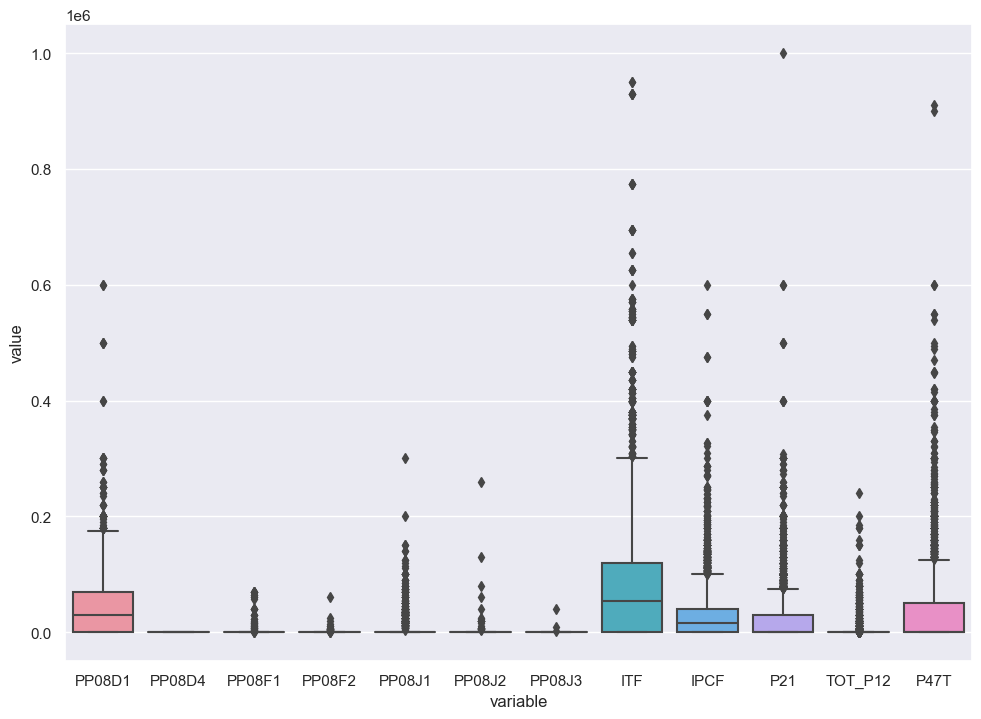

In [13]:
#Boxplots de variables que chequeamos outliers
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x="variable", y="value", data=pd.melt(eph[variables_para_outliers]))



In [14]:
#Generamos Interquantile Ranges, con eso sacamos los que queden afuera
#Asimetrico por ser ingreso una variable con lower bound pero no upper bound
Qlow = eph[variables_para_outliers].quantile(0)
Qhigh = eph[variables_para_outliers].quantile(0.90)
IQR = Qhigh - Qlow
print(IQR)
eph_inc = eph[variables_para_outliers]
eph_out = eph_inc[~((eph_inc < (Qlow - 1.5 * IQR)) |(eph_inc > (Qhigh + 1.5 * IQR))).any(axis=1)]
indexes = eph_out.index.values.tolist() 
eph=eph.loc[indexes]
print('No es sorpresa que sean 0 las que en graficos no tienen outliers faciles de observar a ojo. Notar que todas con outliers para arriba, no borramos los 0, mas en variables donde sean NO RESPONDE.')

PP08D1     110000.0
PP08D4          0.0
PP08F1          0.0
PP08F2          0.0
PP08J1      13000.0
PP08J2          0.0
PP08J3          0.0
ITF        203000.0
IPCF        70800.0
P21         80009.0
TOT_P12         9.0
P47T        95709.0
dtype: float64
No es sorpresa que sean 0 las que en graficos no tienen outliers faciles de observar a ojo. Notar que todas con outliers para arriba, no borramos los 0, mas en variables donde sean NO RESPONDE.


In [15]:
eph['ITF'].min()

0

In [16]:
#Chequeamos tipo de las variable restantes
eph.info(verbose=True)
print("Son todas object, int64 o float64, visto en una tabla:")
eph.dtypes.value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5459 entries, 0 to 6705
Data columns (total 198 columns):
 #    Column      Dtype  
---   ------      -----  
 0    CODUSU      object 
 1    ANO4        int64  
 2    TRIMESTRE   int64  
 3    NRO_HOGAR   int64  
 4    COMPONENTE  int64  
 5    H15         int64  
 6    REGION      int64  
 7    MAS_500     object 
 8    AGLOMERADO  int64  
 9    PONDERA     int64  
 10   CH03        int64  
 11   CH04        int64  
 12   CH05        object 
 13   CH06        int64  
 14   CH07        int64  
 15   CH08        int64  
 16   CH09        int64  
 17   CH10        int64  
 18   CH11        int64  
 19   CH12        int64  
 20   CH13        int64  
 21   CH14        float64
 22   CH15        int64  
 23   CH16        int64  
 24   NIVEL_ED    int64  
 25   ESTADO      int64  
 26   CAT_OCUP    int64  
 27   CAT_INAC    int64  
 28   PP02C1      int64  
 29   PP02C2      int64  
 30   PP02C3      int64  
 31   PP02C4      int64  
 32   PP

int64      126
float64     69
object       3
dtype: int64

In [17]:
#Definimos que variables no son categoricas
categoricas = ['CH03', 'CH04', 'CH07', 'CH08', 'CH09', 'CH10', 'CH11', 'CH12', 'CH13', 'CH14', 'CH15', 'CH16', 'NIVEL_ED',
               'ESTADO', 'CAT_OCUP', 'CAT_INAC', 'PP02C1', 'PP02C2', 'PP02C3', 'PP02C4', 'PP02C5', 'PP02C6', 'PP02C7', 
               'PP02C8', 'PP02E', 'PP02H', 'PP02I', 'PP03C', 'PP03G', 'PP03H', 'PP03I', 'PP03J', 'INTENSI', 'PP04A', 
               'PP04B1', 'PP04B3_MES', 'PP04B3_ANO', 'PP04B3_DIA', 'PP04C', 'PP04C99', 'PP04G', 'PP05B2_MES', 'PP05B2_ANO',
               'PP05B2_DIA', 'PP05C_1', 'PP05C_2', 'PP05C_3', 'PP05E', 'PP05F', 'PP05H', 'PP06A', 'PP06E', 'PP06H', 'PP07A',
               'PP07C', 'PP07D', 'PP07E', 'PP07F1', 'PP07F2', 'PP07F3', 'PP07F4', 'PP07F5', 'PP07G1', 'PP07G2', 'PP07G3', 
               'PP07G4', 'PP07G_59', 'PP07H', 'PP07I', 'PP07J', 'PP07K', 'PP09A', 'PP09B', 'PP09C', 'IV1', 'IV2', 'IV3', 
               'IV4', 'IV5', 'IV6', 'IV7', 'IV8', 'IV9', 'IV10', 'IV11', 'IV12_1', 'IV12_2', 'IV12_3', 'II1', 'II2', 'II3', 
               'II3_1', 'II4_1', 'II4_2', 'II4_3', 'II5', 'II5_1', 'II6', 'II6_1', 'II7', 'II8', 'II9', 'V1', 'V2', 'V21', 
               'V22', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17',
               'V18', 'V19_A', 'V19_B', 'IX_TOT', 'IX_MEN10', 'IX_MAYEQ10', 'VII1_1', 'VII1_2', 'VII2_1', 'VII2_2',
               'VII2_3', 'VII2_4']
#Me fijo cuales fueron borradas mas arriba por tener muchos NAs
no_borradas = pd.Index(categoricas).difference(eph.columns).tolist()
#las saco
categoricas = pd.Index(categoricas).difference(no_borradas).tolist()

print(f'Aquellas variables categoricas restantes son: {categoricas}')

Aquellas variables categoricas restantes son: ['CH03', 'CH04', 'CH07', 'CH08', 'CH09', 'CH10', 'CH11', 'CH12', 'CH13', 'CH14', 'CH15', 'CH16', 'NIVEL_ED', 'ESTADO', 'CAT_OCUP', 'CAT_INAC', 'PP02C1', 'PP02C2', 'PP02C3', 'PP02C4', 'PP02C5', 'PP02C6', 'PP02C7', 'PP02C8', 'PP02E', 'PP02H', 'PP02I', 'PP03C', 'PP03G', 'PP03H', 'PP03I', 'PP03J', 'INTENSI', 'PP04A', 'PP04B1', 'PP04B3_MES', 'PP04B3_ANO', 'PP04B3_DIA', 'PP04C', 'PP04C99', 'PP04G', 'PP05B2_MES', 'PP05B2_ANO', 'PP05B2_DIA', 'PP05C_1', 'PP05C_2', 'PP05C_3', 'PP05E', 'PP05F', 'PP05H', 'PP06A', 'PP06E', 'PP06H', 'PP07A', 'PP07C', 'PP07D', 'PP07E', 'PP07F1', 'PP07F2', 'PP07F3', 'PP07F4', 'PP07F5', 'PP07G1', 'PP07G2', 'PP07G3', 'PP07G4', 'PP07G_59', 'PP07H', 'PP07I', 'PP07J', 'PP07K', 'PP09A', 'PP09B', 'PP09C', 'IV1', 'IV2', 'IV3', 'IV4', 'IV5', 'IV6', 'IV7', 'IV8', 'IV9', 'IV10', 'IV11', 'IV12_1', 'IV12_2', 'IV12_3', 'II1', 'II2', 'II3', 'II3_1', 'II4_1', 'II4_2', 'II4_3', 'II5', 'II5_1', 'II6', 'II6_1', 'II7', 'II8', 'II9', 'V1', 'V2

In [18]:
#Las convertimos a categoricas
eph_d=eph.copy()
eph_d[categoricas] = eph_d[categoricas].astype('category')
#Chequeamos
eph_d.dtypes.value_counts()

int64       41
float64     21
category    21
category    18
category    10
category     8
category     5
category     5
category     3
category     3
object       3
category     3
category     2
category     2
category     2
category     2
category     2
category     2
category     2
category     2
category     2
category     2
category     2
category     2
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
dtype: int64

In [19]:
#Reemplazamos NAs de categoricas por -1
for col in categoricas:
    eph_d[col]=eph_d[col].cat.add_categories(['-1'])
    eph_d[col]=eph_d[col].fillna('-1')
eph_d[categoricas].head(40)

,CH03,CH04,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH14,CH15,CH16,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,PP02C1,PP02C2,PP02C3,PP02C4,PP02C5,PP02C6,PP02C7,PP02C8,PP02E,PP02H,PP02I,PP03C,PP03G,PP03H,PP03I,PP03J,INTENSI,PP04A,PP04B1,PP04B3_MES,PP04B3_ANO,PP04B3_DIA,PP04C,PP04C99,PP04G,PP05B2_MES,PP05B2_ANO,PP05B2_DIA,PP05C_1,PP05C_2,PP05C_3,PP05E,PP05F,PP05H,PP06A,PP06E,PP06H,PP07A,PP07C,PP07D,PP07E,PP07F1,PP07F2,PP07F3,PP07F4,PP07F5,PP07G1,PP07G2,PP07G3,PP07G4,PP07G_59,PP07H,PP07I,PP07J,PP07K,PP09A,PP09B,PP09C,IV1,IV2,IV3,IV4,IV5,IV6,IV7,IV8,IV9,IV10,IV11,IV12_1,IV12_2,IV12_3,II1,II2,II3,II3_1,II4_1,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II8,II9,V1,V2,V21,V22,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19_A,V19_B,IX_TOT,IX_MEN10,IX_MAYEQ10,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
0,1,2,2,1,1,2,0,7,1,-1,1,1,6,1,2,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,7.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1,4,1,3,1,1,1,1,1,1,1,2,2,2,4,2,1,1,1,2,2,2,0,2,0,1,1,1,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,0,3,1,2,3,0,0,0
1,2,1,2,1,1,2,0,4,1,-1,1,1,4,3,0,1,0,0,0,0,0,0,0,0,0,2,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,4,1,3,1,1,1,1,1,1,1,2,2,2,4,2,1,1,1,2,2,2,0,2,0,1,1,1,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,0,3,1,2,3,0,0,0
3,1,1,3,1,2,2,0,2,2,2.0,3,1,1,3,0,4,0,0,0,0,0,0,0,0,0,2,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,2,1,4,1,1,1,1,1,1,1,2,2,2,2,2,2,0,1,2,2,2,0,2,0,1,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,0,1,1,0,98,0,0,0
4,1,2,5,4,1,2,0,4,2,2.0,1,1,3,1,2,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2.0,0.0,2.0,2.0,3.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,3.0,2.0,7.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1,2,1,2,1,1,2,1,1,2,1,2,2,2,2,2,2,0,1,1,2,2,0,2,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,1,1,1,2,2,2,2,0,2,1,3,98,0,0,0
5,3,2,5,4,1,1,1,4,2,4.0,1,1,3,3,0,3,0,0,0,0,0,0,0,0,0,2,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,2,1,2,1,1,2,1,1,2,1,2,2,2,2,2,2,0,1,1,2,2,0,2,0,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,1,1,1,2,2,2,2,0,2,1,3,98,0,0,0
6,1,2,3,1,1,2,0,4,2,3.0,1,1,3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2.0,0.0,2.0,2.0,2.0,2.0,1.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,0.0,1,2,2,4,1,1,1,1,1,1,1,2,2,2,2,1,2,0,2,2,2,0,0,0,0,1,2,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,1,2,2,2,2,1,0,1,1,0,98,0,0,0
7,1,2,3,1,1,2,0,2,1,-1,2,1,2,3,0,1,0,0,0,0,0,0,0,0,0,2,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,2,2,1,1,1,1,1,1,2,2,2,2,1,1,2,0,1,2,2,2,0,2,0,1,1,1,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,0,1,1,0,97,0,0,0
8,1,1,1,1,1,2,0,4,1,-1,1,1,4,3,0,1,0,0,0,0,0,0,0,0,0,2,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2,2,1,9,1,1,1,1,1,1,1,2,2,2,2,2,2,0,1,1,2,2,0,2,0,2,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,1,2,2,2,2,3,0,3,2,0,98,0,0,0
9,2,2,1,1,1,2,0,4,1,-1,1,1,4,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2.0,0.0,2.0,2.0,2.0,1.0,2.0,0.0,0.0,0.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,5.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2,2,1,9,1,1,1,1,1,1,1,2,2,2,2,2,2,0,1,1,2,2,0,2,0,2,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,1,2,2,2,2,3,0,3,2,0,98,0,0,0
10,3,2,5,1,1,1,1,6,2,2.0,1,1,5,1,3,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2.0,0.0,2.0,2.0,2.0,1.0,2.0,0.0,0.0,0.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0

In [20]:
columnas_llenar_con_ceros = eph.columns[eph.isnull().any()]
eph[columnas_llenar_con_ceros]=eph[columnas_llenar_con_ceros].fillna(0)

6) Elegimos como relevantes las variabes para predecir pobreza varias de las mencionadas en el punto 1, sumado a 'NIVEL_ED', asumiendo que menor nivel educativo se relaciona con mayor probabilidad de ser pobre. Las demas justificaciones son las mismas que en el primer inciso.

In [21]:
#Estadisticas descriptivas 
listadeelegidas = ['NIVEL_ED','V5', 'II8', 'IX_MEN10', 'IV7' ]
summary = eph[listadeelegidas].describe(include='all')
print(summary)
        

          NIVEL_ED           V5          II8     IX_MEN10          IV7
count  5459.000000  5459.000000  5459.000000  5459.000000  5459.000000
mean      3.645539     1.783477     1.316725     0.573731     1.231361
std       1.788625     0.424184     0.572258     0.912945     0.434157
min       1.000000     1.000000     0.000000     0.000000     1.000000
25%       2.000000     2.000000     1.000000     0.000000     1.000000
50%       4.000000     2.000000     1.000000     0.000000     1.000000
75%       5.000000     2.000000     2.000000     1.000000     1.000000
max       7.000000     9.000000     4.000000     5.000000     4.000000


7. Agregamos la columna adulto_equiv y adulto_equiv_hogar

In [22]:
df_equiv = pd.read_excel('tabla_adulto_equiv.xlsx')

df_equiv.loc[1,"Edad"]=1


for i in range(0,18):
    df_equiv.loc[i,"Edad"]= i 

for i in range(18,30): #18-29 años 0.76/1.02
    df_equiv.loc[i]= [i,0.76,1.02] 

for i in range(30,46): #30-45 años 0.77/1
    df_equiv.loc[i]= [i,0.77,1] 

for i in range(46,61): #46-60 años 0.76/1
    df_equiv.loc[i]= [i,0.76,1] 

for i in range(61,76): #61-75 años 0.67/0.83
    df_equiv.loc[i]= [i,0.67,0.83]

for i in range(76,106): #18-29 años 0.63/0.74. La edad max en la EPH es 105 años. 
    df_equiv.loc[i]= [i,0.63,0.74] 

df_equiv = df_equiv.rename(columns={'Edad':'CH06'})
print(df_equiv)

      CH06  Mujeres  Varones
0        0     0.35     0.35
1        1     0.37     0.37
2        2     0.46     0.46
3        3     0.51     0.51
4        4     0.55     0.55
5        5     0.60     0.60
6        6     0.64     0.64
7        7     0.66     0.66
8        8     0.68     0.68
9        9     0.69     0.69
10      10     0.70     0.79
11      11     0.72     0.82
12      12     0.74     0.85
13      13     0.76     0.90
14      14     0.76     0.96
15      15     0.77     1.00
16      16     0.77     1.03
17      17     0.77     1.04
18      18     0.76     1.02
19      19     0.76     1.02
20      20     0.76     1.02
21      21     0.76     1.02
22      22     0.76     1.02
23    23.0     0.76     1.02
24    24.0     0.76     1.02
25    25.0     0.76     1.02
26    26.0     0.76     1.02
27    27.0     0.76     1.02
28    28.0     0.76     1.02
29    29.0     0.76     1.02
30    30.0     0.77     1.00
31    31.0     0.77     1.00
32    32.0     0.77     1.00
33    33.0    

In [23]:
df_eph= eph.merge(df_equiv, on='CH06')

for i in range(len(df_eph)):
    if df_eph.loc[i,"CH04"]==1:
        df_eph.loc[i,"adulto_equiv"]=df_eph.loc[i,"Varones"]
    elif df_eph.loc[i,"CH04"]==2:
        df_eph.loc[i,"adulto_equiv"]=df_eph.loc[i,"Mujeres"]


df_eph.drop (["Varones","Mujeres"] , axis =1 , inplace = True)

In [24]:
df_sum=df_eph.groupby(['CODUSU', 'NRO_HOGAR'])[['adulto_equiv']].agg('sum')
df_sum.reset_index( inplace = True )
df_sum = df_sum.rename(columns={'adulto_equiv':'ad_equiv_hogar'})

df_eph=df_eph.merge(df_sum, on=["CODUSU", "NRO_HOGAR"])
df_eph=df_eph.sort_values(by="CODUSU")

#El data frame relevante ahora es df_eph


8. Dividimos la base en respondieron y no respondieron 

In [25]:
#Guardamos las obs que respondieron en el df 'df_respondieron':
df_respondieron = df_eph.drop(df_eph[df_eph['ITF']<=0].index)
df_respondieron.reset_index(inplace=True, drop=True)

##Guardamos las obs que no respondieron en el df 'df_norespondieron':
df_norespondieron= df_eph.drop(df_eph[df_eph['ITF']>0].index) 
df_norespondieron.reset_index( inplace = True )
print(len(df_norespondieron)) #chequeamos que la cantidad de obs sea igual a no_resp

2146


Agregamos la variable "ingreso_necesario"

In [26]:
df_respondieron["ingreso_necesario"]=df_respondieron["ad_equiv_hogar"]*(27197.64) #$27197.64 es la CBA


9. Agregamos la variable "pobre"

In [27]:
df_respondieron["Pobre"]=0

for i in range(len(df_respondieron)):
    if df_respondieron.loc[i,"ITF"] < df_respondieron.loc[i,"ingreso_necesario"] :
        df_respondieron.loc[i,"Pobre"]= 1

10. Calculamos la tasa de hogares pobres para GBA, utilizando el ponderador PONDICH.


In [28]:
#Me quedo solo con GBA
df_respondieron_GBA =df_respondieron[df_respondieron['REGION']==1]

In [29]:
#Creamos base con solo una observacion por hogar
eph_hogares=df_respondieron_GBA.groupby(['CODUSU','NRO_HOGAR']).agg({"Pobre" : "mean","PONDIH" : "sum"})
#Sumamos cuanto hay de cada uno. 
sumas=eph_hogares.groupby("Pobre").PONDIH.sum().to_frame()
eph_porcentajes = sumas.apply(lambda x:
                                                 100 * x / float(x.sum()))
print(eph_porcentajes)


          PONDIH
Pobre           
0.0    65.659653
1.0    34.340347


Notese que el porcentaje de pobres utilizando este metodo solo para REGION del GBA (distinto era si usabamos AGLOMERADO 33, partidos del GBA) es de 34.34%, mas de 4 p.p. por debajo del 39,2% reportado por INDEC considerando a nivel individual. 

## PARTE II

1) Definimos la función evalua_metodo. Qué toma como inputs las bases de train y test para X e Y y el modelo deseado (LogisticRegression, LinearDiscriminantAnalysis o KNeighborsClassifier) con su hiperparámetro. Y devuelve una colección de métricas del modelo que consiste en accuracy, auc y ecm.

In [97]:
def evalua_metodo(X_train, X_test, y_train, y_test, model, k=5, landa=1):
    '''    
    Toma como parametros las bases de train y test y el modelo deseado: LogisticRegression, LinearDiscriminantAnalysis,KNeighborsClassifier
    Devuelve las métricas: Accuracy, AUC y ECM.
    '''
    if model==KNeighborsClassifier:
        y = model(k).fit(X_train, y_train)
    elif model== LogisticRegression:
        y = model(C=1/landa).fit(X_train, y_train)
    elif model== LinearDiscriminantAnalysis:
        y = model().fit(X_train, y_train)
    else:
        y = model.fit(X_train, y_train)
    
    y_pred = y.predict(X_test)

    matriz_confusion = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, tresholds = roc_curve(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    ecm = mean_squared_error(y_test, y_pred)

    df_metrics = pd.DataFrame({'modelo': [model], 'accuracy': [accuracy], 'auc':[auc], 'ecm':[ecm]})

    return df_metrics

2) Definimos la función cross_validation(model, k,x,y,standard=false) que toma como input el modelo desado (LogisticRegression, LinearDiscriminantAnalysis o KNeighborsClassifier),la cantidad de particiones 'k' para hacer CV, las bases X e Y y standard=True indica si se quiere estandarizar las variables para hacer CV. La función devuelve la media de los ECM de las k estimaciones realizadas por el método de cross-validation.

In [52]:
def cross_validation(model, k, x, y, standard=False):
    sc = StandardScaler()
    
    if standard==True:
    
        kf = KFold(n_splits=k, shuffle=True)

        ecm = []

        for i, (train_index, test_index) in enumerate(kf.split(x)):   
            x_train, x_test = x.iloc[list(train_index)], x.iloc[list(test_index)]  
            y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

            # Estandarizamos las observaciones de entrenamiento
            x_train_transformed = pd.DataFrame(sc.fit_transform(x_train),index=x_train.index, columns=x_train.columns)
            # Estandarizamos las observaciones de test
            x_test_transformed = pd.DataFrame(sc.transform(x_test),index=x_test.index, columns=x_test.columns)

            ecm2 = evalua_metodo(x_train_transformed, x_test_transformed, y_train, y_test, model)
            ecm3 = ecm2['ecm'][0]
            ecm.append(ecm3)
        
        final_ecm = statistics.mean(ecm)

        return final_ecm
    
    elif standard==False:
    
        kf = KFold(n_splits=k, shuffle=True)

        ecm = []

        for i, (train_index, test_index) in enumerate(kf.split(x)):   
            x_train, x_test = x.iloc[list(train_index)], x.iloc[list(test_index)]  
            y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

            ecm2 = evalua_metodo(x_train, x_test, y_train, y_test, model)
            ecm3 = ecm2['ecm']
            ecm.append(ecm3)

        final_ecm = statistics.mean(ecm)

        return final_ecm

3) Definimos la función evalua_config(landa, k, x, y, l_1ratio) que toma cómo inputs una collección de valores de lambdas (pueden ser una matriz o lista), el k de cross-validation, las bases X e Y y un valor para l1_ratio que debe estar entre 0 y 1 (1 indica que la función hace Lasso, 0 que hace Ridge, y cualquier valor intermedio hace Elastic Net ponderando en 'l1_ratio' a Lasso y '1-l1_ratio' a Ridge). Con esta información la función se encarga de calcular el lambda que minimiza el ECM por Cross-validation para la regresion logistica estimando por la elección de Lasso/Ridge/Elastic Net. Retorna el lambda óptimo y el valor del ECM para ese lambda.

In [32]:
def evalua_config (landa, k, x, y, l1_ratio=1):
    '''
    Toma cómo input una serie de valores de Lambda y el K para CV, y devuelve el lambda que minimiza el ECM por CV, usando elastic net para reg_logit
    l1_ratio=1 se hace Lasso
    l1_ratio=0 se hace Ridge
    0 <l1_ratio< 1 combinación de ambos en elastic net.  
    '''
    
    ret={}
    for elem in landa:
        clf_en_LR = LogisticRegression(C= 1/elem ,  l1_ratio=l1_ratio)
        ecm=cross_validation(clf_en_LR,k, x, y, standard=True)
        ret[elem]= ecm 

        
    return max(ret, key=ret.get)

4) Definimos la función evalua_metodos(k_cv,k_knn, landa_max, x_train, x_test , y_train, y_test, x, y) que toma cómo inputs el k de Cross-Validation, el k de KNN, el valor máximo a testear de lambda para el modelo de regresión logistica, las bases de train y test de X e Y, y las bases completas de X e Y. La función se encarga de calcular los modelos KNN(con el k que le pasamos cómo input), Regresión logistica (con el lambda óptimo por Cross-Valdation) y Análisis Lineal de Discriminante y devuelve una tabla con las métricas correspondientes a cada modelo, entre las que se encuentran: hiperparámetro elegido, Accuracy, Auc y ECM.

In [95]:
def evalua_multiples_metodos (k_cv,k_knn, landa_max, x_train, x_test , y_train, y_test, x, y): 
    
    modelos = ['regresion_logistica','k_vecinos_cercanos','analisis_discriminante']

    landas= np.arange(0.01, landa_max,1).tolist()

    matriz = pd.DataFrame(columns=["Modelo", "Hiperparametro","Precisión", "AUC", "ECM"])

    for modelo in modelos:
        if modelo == 'regresion_logistica':
            landa_optimo = evalua_config( landas, k_cv ,x, y) #hiperparametro landa
            metricas_log= evalua_metodo(x_train, x_test , y_train, y_test , LogisticRegression, landa=landa_optimo )
            results = [modelo, landa_optimo, metricas_log['accuracy'][0], metricas_log['auc'][0], metricas_log['ecm'][0]]
            matriz.loc[len(matriz)] = results

        elif modelo =='k_vecinos_cercanos':
            metricas_kvc = evalua_metodo( x_train, x_test, y_train, y_test, KNeighborsClassifier, k=k_knn)
            results = [modelo, k_knn, metricas_kvc['accuracy'][0], metricas_kvc['auc'][0], metricas_kvc['ecm'][0]]
            matriz.loc[len(matriz)] = results
        
        elif modelo == 'analisis_discriminante':
            metricas_ad = evalua_metodo(x_train, x_test, y_train, y_test, LinearDiscriminantAnalysis)
            results = [modelo, "NA", metricas_ad['accuracy'][0], metricas_ad['auc'][0], metricas_ad['ecm'][0]]
            matriz.loc[len(matriz)] = results
        
    
    return(matriz)

## PARTE III

1) Eliminamos todas variables de ingreso. Especificamos a que tipo de ingreso esta relacionada cada una. Dado que borramos algunas por tener demasiados NAs, borramos obviamente las no previamente decartadas, sacando la diferencia entre las variables definidas y las ya borradas. 

In [34]:
variables_ingreso = [
    "ITF","DECIFR","IDECIFR","RDECIFR","GDECIFR", "PDECIFR","ADECIFR", #Ingreso total familiar
    "IPCF", "DECCFR", "IDECCFR", "RDECCFR", "GDECCFR", "PDECCFR", "ADECCFR", "PONDIH", #Ingreso per capita familiar
    "PP06A", "PP06C", "PP06D", "PP06E", "PP06H", #Ingreso de las ocupaciones principales de independientes
    "PP08D1", "PP08D4", "PP08F1", "PP08F2", "PP08J1", "PP08J2", "PP08J3",#Ingreso de las ocupaciones principales de asalariados
    "P21", "DECOCUR", "IDECOCUR", "RDECOCUR", "GDECOCUR", "PDECOCUR", "ADECOCUR", "PONDIIO", #Ingreso de la ocupacion principal
    "TOT_P12", #Ingreso de otras ocupaciones
    "P47T", "DECINDR", "IDECINDR", "RDECINDR", "GDECINDR", "PDECINDR", "ADECINDR", "PONDII",#Ingreso total individual
    "V2_M", "V3_M", "V4_M", "V5_M", "V8_M", "V9_M", "V10_M", "V11_M", "V12_M", "V18_M", "V19_AM", "V21_M", "T_VI", #Ingresos no laborales
    "adulto_equiv", "ad_equiv_hogar",  "ingreso_necesario"#Equivalentes e ingreso necesario
]
#Me fijo cuales fueron borradas mas arriba por tener muchos NAs
borradas = pd.Index(variables_ingreso).difference(df_norespondieron.columns).tolist()
#las saco
variables_ingreso_no_borradas = pd.Index(variables_ingreso).difference(borradas).tolist()

#Eliminamos
df_respondieron.drop(columns = variables_ingreso_no_borradas)
df_respondieron.drop(columns = ['ingreso_necesario']) #Esta solo en df_respondieron
df_norespondieron.drop(columns = variables_ingreso_no_borradas)

print(df_respondieron.head(10))
print(df_norespondieron.head(10))



                          CODUSU  ANO4  TRIMESTRE  NRO_HOGAR  COMPONENTE  H15  \
0  TQRMNOPPQHJMNRCDEIJAH00693035  2022          1          1           4    0   
1  TQRMNOPPQHJMNRCDEIJAH00693035  2022          1          1           1    1   
2  TQRMNOPPQHJMNRCDEIJAH00693035  2022          1          1           3    0   
3  TQRMNOPPQHJMQLCDEIJAH00702455  2022          1          1           1    1   
4  TQRMNOPPQHJNMQCDEIJAH00698190  2022          1          1           4    0   
5  TQRMNOPPQHJNMQCDEIJAH00698190  2022          1          1           1    1   
6  TQRMNOPPQHJNMQCDEIJAH00698190  2022          1          1           3    1   
7  TQRMNOPPQHJNMQCDEIJAH00698190  2022          1          1           2    1   
8  TQRMNOPPQHKMQRCDEIJAH00780809  2022          1          1           3    1   
9  TQRMNOPPQHKMQRCDEIJAH00780809  2022          1          1           5    0   

   REGION MAS_500  AGLOMERADO  PONDERA  CH03  CH04                 CH05 CH06  \
0       1       S          3

Definimos y como la variable de si es pobre o no. X es el resto de variables, agregamos constante. 

In [35]:
y=df_respondieron['Pobre'] 
X=df_respondieron.loc[:, df_respondieron.columns != 'Pobre']
X['Constante']=1

2) Corremos la funcion evalua_multiples_metodos.

In [36]:
#Recordemos que tenemos 2 data base relevantes: df_respondieron y df_norespondieron
#Pasamos a float la variable MAS_500 que es de tipo String:
for i in range(len(df_respondieron)):
    if df_respondieron.loc[i,"MAS_500"] == "S" :
        df_respondieron.loc[i,"MAS_500"]= 1
    elif df_respondieron.loc[i,"MAS_500"] == "N":
        df_respondieron.loc[i,"MAS_500"]=0 

for i in range(len(df_norespondieron)):
    if df_norespondieron.loc[i,"MAS_500"] == "S" :
        df_norespondieron.loc[i,"MAS_500"]= 1
    elif df_norespondieron.loc[i,"MAS_500"] == "N":
        df_norespondieron.loc[i,"MAS_500"]=0

In [39]:
#Eliminamos CODUSU Y CH05, que son strings
df_norespondieron.drop (["CODUSU", "CH05"] , axis =1 , inplace = True)
df_respondieron.drop (["CODUSU", "CH05"] , axis =1 , inplace = True)

KeyError: "['CODUSU', 'CH05'] not found in axis"

In [42]:
y=df_respondieron['Pobre'] 
X=df_respondieron.loc[:, df_respondieron.columns != 'Pobre']
X['Constante']=1

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
evalua_multiples_metodos (5,5, 3, X_train, X_test , y_train, y_test, X, y)

/Volumes/GoogleDrive/My Drive/UdeSA/Materias/Big Data/udesa-big-data/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Volumes/GoogleDrive/My Drive/UdeSA/Materias/Big Data/udesa-big-data/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Volumes/GoogleDrive/My Drive/UdeSA/Materias/Big Data/udesa-big-data/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is on

,Modelo,Hiperparametro,Precisión,AUC,ECM
0,regresion_logistica,2.01,0.997988,0.996894,0.002012
1,k_vecinos_cercanos,5.0,0.969819,0.963121,0.030181
2,analisis_discriminante,NA,0.947686,0.949987,0.052314


3) Se utiliza un metodo de K-Fold cross validation con la intencion de minimizar el error de prediccion por fuera de la muestra. Con varios $\lambda$ alternativos calculamos el error de pronostico partiendo los datos al azar en $K$ partes, ajustandolo dejando al azar afuera algunas de estas. Se elige el $\lambda$ con mejor predicciones. 

No se usan los datos de test ya que queremos comparar desempeño entre modelos, todos entrenados con la base de train. Como luego los compararemos en base al desempeño en test, no tiene sentido que lo elijamos con este mismo. 

4) K grande maximiza los datos utilizados para estimar, por lo que resulta sensible a los valores especificos, dependiendo el error de lo que pase con pocos datos de test.

K chico maximiza los datos para utilizados para evaluar, el modelo estimado resulta menos preciso por ello.

$K=n$ resulta ser leave one out, estimandolo n veces con $n-1$ datos. 

5) 

In [100]:
# Ridge y Lasso
lambdas=10**np.linspace(-5,5,11)
landa_optimo_lasso = evalua_config(lambdas, 10, X, y, l1_ratio=1) #Lasso
landa_optimo_ridge = evalua_config(lambdas, 10, X, y, l1_ratio=0) #Ridge

/Volumes/GoogleDrive/My Drive/UdeSA/Materias/Big Data/udesa-big-data/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Volumes/GoogleDrive/My Drive/UdeSA/Materias/Big Data/udesa-big-data/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Volumes/GoogleDrive/My Drive/UdeSA/Materias/Big Data/udesa-big-data/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is on

In [101]:
print(landa_optimo_ridge)
print(landa_optimo_lasso)

100000.0
100000.0


El λ elegido con Ridge es y Lasso es .